## Краткая информация и цель проекта

Интернет-магазин продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться.

Необходимо на основе собранных данных о поведении клиентов и об их потребительских привычек построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

Модель должна учесть данные финансового департмамента о прибыльности клиента, а именно какой доход каждый покупатель приносил компании в последние три месяца.

Итоговое решение &mdash; персонализированные предложения для клиентов, разделенных по сегментам.

## Описание данных

Буду работать с четырьмя датасетами:
- market_file.csv
- market_money.csv
- market_time.csv
- money.csv

### market_file.csv
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив\_6\_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

### market_money.csv
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

### market_time.csv
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

### money.csv
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

## План работы

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение таблиц
5. Корреляционный анализ
6. Использование пайплайнов
7. Анализ важности признаков
8. Сегментация покупателей
9. Общий вывод

### Загрузка данных

In [1]:
!pip install phik
!pip install shap
!pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction import DictVectorizer
from warnings import simplefilter

#### market_file.csv

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
market_file.columns = [x.lower() for x in market_file.columns]
market_file.rename(columns={'покупательская активность': 'покупательская_активность',
                            'тип сервиса': 'тип_сервиса',
                            'разрешить сообщать': 'разрешить_сообщать'}, inplace=True)
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


#### market_money.csv

In [5]:
market_money = pd.read_csv('/datasets/market_money.csv')
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [6]:
market_money.columns = [x.lower() for x in market_money.columns]
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


#### market_time.csv

In [7]:
market_time = pd.read_csv('/datasets/market_time.csv')
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
market_time.columns = [x.lower() for x in market_time.columns]
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


#### money.csv

In [9]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [10]:
money.columns = [x.lower() for x in money.columns]
money.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Промежуточный вывод: датасеты загрузил, данные в них проверил на корректность. Единственное, что беспокоит, &mdash; в датасете **money** в столбце _прибыль_ значения маленькие, может быть, надо будет умножить весь столбец на 10 (или 100, или 1000).

### Предобработка данных

#### market_file

In [11]:
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Хочу поменять строковые значения в категориальных столбцах на числа там, где это возможно и соотносится со здравым смыслом.

In [12]:
display(market_file['покупательская_активность'].unique())
display(market_file['тип_сервиса'].unique())
display(market_file['разрешить_сообщать'].unique())
display(market_file['популярная_категория'].unique())

array(['Снизилась', 'Прежний уровень'], dtype=object)

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

array(['да', 'нет'], dtype=object)

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [13]:
market_file['покупательская_активность'] = market_file['покупательская_активность']\
                                    .replace(['Прежний уровень', 'Снизилась'], [0, 1])
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')
market_file['популярная_категория'] = market_file['популярная_категория']\
                                        .replace('Косметика и аксесуары', 'Косметика и аксессуары')
#market_file['тип_сервиса'] = market_file['тип_сервиса'].replace(['стандартт', 'стандарт', 'премиум'], [0, 0, 1])
#market_file['разрешить_сообщать'] = market_file['разрешить_сообщать'].replace(['нет', 'да'], [0, 1])
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,1,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [14]:
# проверю, не допустил ли где ошибки
display(market_file['покупательская_активность'].unique())
display(market_file['тип_сервиса'].unique())
display(market_file['разрешить_сообщать'].unique())

array([1, 0])

array(['премиум', 'стандарт'], dtype=object)

array(['да', 'нет'], dtype=object)

In [15]:
# общая информация, проверка пропусков и типов данных
market_file.info()
display(market_file.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   int64  
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

Пропусков нет, сразу проверил тип данных в колонках &mdash; все корректно.

In [16]:
# проверка дубликатов
market_file.duplicated().sum()

0

Дубликатов тоже нет.

#### market_money

In [17]:
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [18]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [19]:
# общая информация, проверка пропусков и типов данных
market_money.info()
display(market_money.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


id         0
период     0
выручка    0
dtype: int64

Пропусков нет, типы данных корректны.

In [20]:
# проверка дубликатов
market_money.duplicated().sum()

0

Дубликатов тоже нет.

#### market_time

In [21]:
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [22]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [23]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
display(market_time['период'].unique())
display(market_time.head())

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [24]:
# общая информация, проверка пропусков и типов данных
market_time.info()
display(market_time.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


id        0
период    0
минут     0
dtype: int64

In [25]:
# проверка дубликатов
market_money.duplicated().sum()

0

Пропусков нет, дубликатов нет, данные в порядке.

#### money

In [26]:
# общая информация, проверка пропусков и типов данных
money.info()
display(money.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


id         0
прибыль    0
dtype: int64

In [27]:
# проверка дубликатов
money.duplicated().sum()

0

Пропусков нет, дубликатов нет, данные в порядке. На этапе загрузки датасета заметил маленькие значения в столбце _прибыль_, надо проверить максимальное значение в этом столбце.

In [28]:
money[money['прибыль'] == money['прибыль'].max()]

,id,прибыль
53,215401,7.43


In [29]:
market_money[market_money['id'] == money[money['прибыль'] == money['прибыль'].max()]['id'].iloc[0]]

,id,период,выручка
159,215401,текущий_месяц,6065.9
160,215401,препредыдущий_месяц,4833.0
161,215401,предыдущий_месяц,5548.5


В датасете **money** хранятся данные о среднемесячной прибыли с каждого покупателя за последние три месяца. Прибыль в 22.5 рубля при покупках на сумму в 16000 мне кажется неверной. Считаю, что весь столбец _прибыль_ в **money** нужно умножить на 100 (умножение на 10/1000 противоречит здравому смыслу).

In [30]:
#['прибыль'] = money['прибыль'].apply(lambda x: x*100)
#money.head()
#все-таки буду работать с тем, что есть, без преобразования

Промежуточный вывод: во всех датасетах, где это было возможно и имело смысл, поменял строковые значения категориальных данных на числовые. Проверил данные на дубликаты и пропуски.

### Исследовательский анализ данных

#### market_file

Сначала построю круговые диаграммы для категориальных переменных.

In [31]:
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,1,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [32]:
def pie_diag(df, i):
    plt.figure
    df1 = df.groupby(i)[i].count().sort_values(ascending=False)
    labels = df1.index
    n = len(labels)
    colors = sns.color_palette('pastel')[0:n]
    plt.pie(df1, labels=labels, colors = colors, autopct='%1.1f%%')

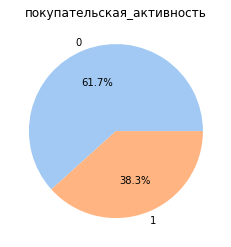

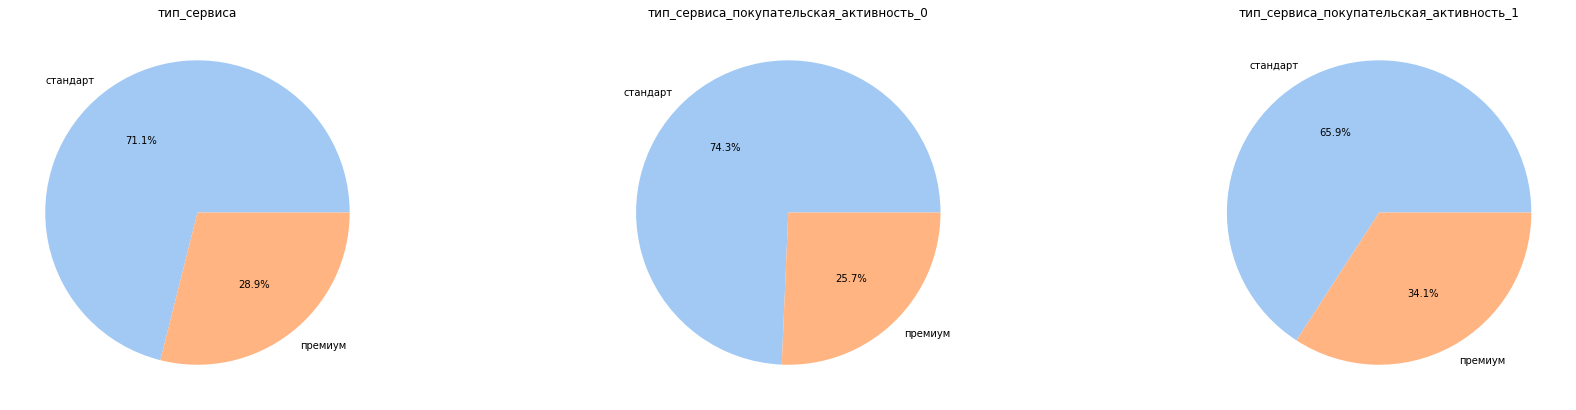

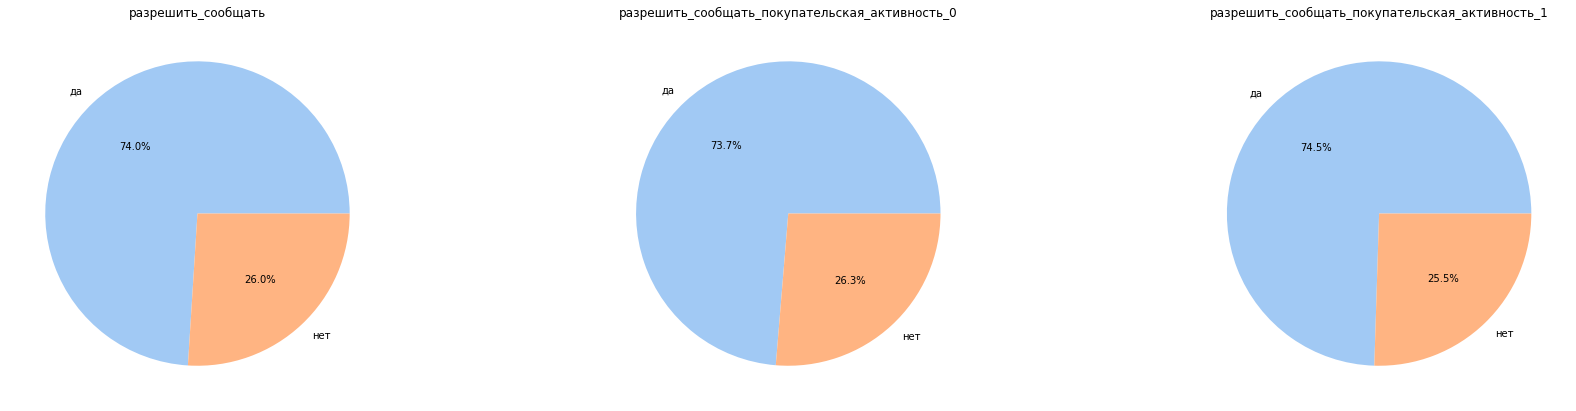

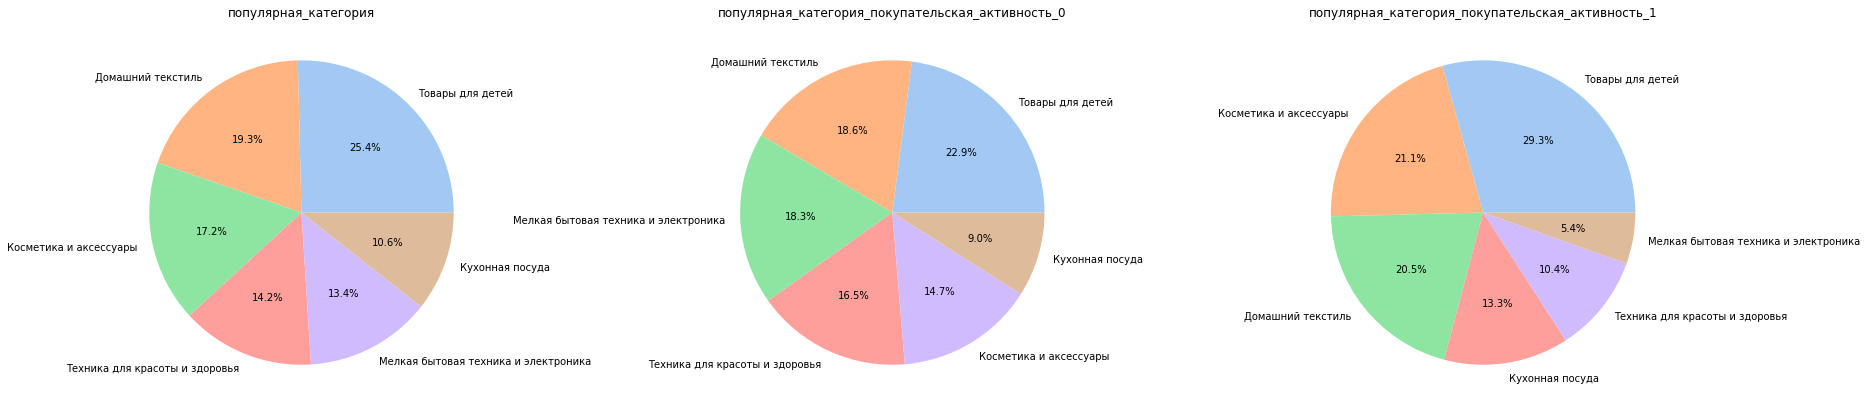

In [33]:
cat_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
target = 'покупательская_активность'
plt.title(target)
pie_diag(market_file, target)
plt.show()
for i in cat_columns:
    plt.rcParams['figure.figsize'] = [30, 7]
    plt.subplot(1, 3, 1)
    plt.title(i)
    pie_diag(market_file, i)
    plt.subplot(1, 3, 2)
    plt.title(i+'_покупательская_активность_0')
    pie_diag(market_file[market_file[target] == 0], i)
    plt.subplot(1, 3, 3)
    plt.title(i+'_покупательская_активность_1')
    pie_diag(market_file[market_file[target] == 1], i)
    plt.show()

Теперь посмотрю на распределение количественных данных.

In [34]:
num_columns = market_file.columns.to_list()
num_columns = [x for x in num_columns if x not in cat_columns]
num_columns.remove('id')
num_columns.remove(target)
num_columns

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит']

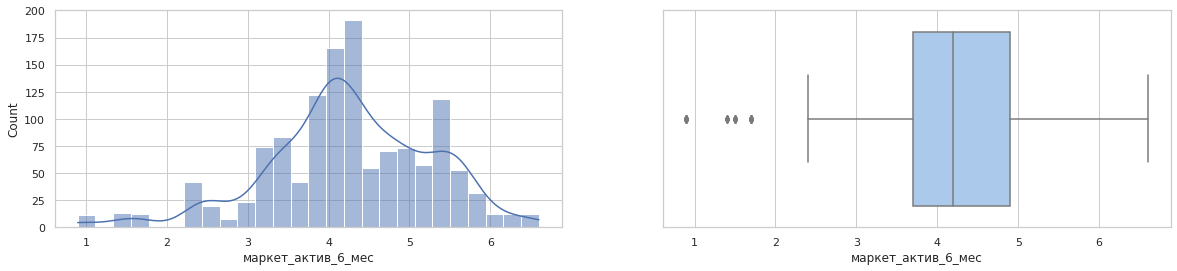

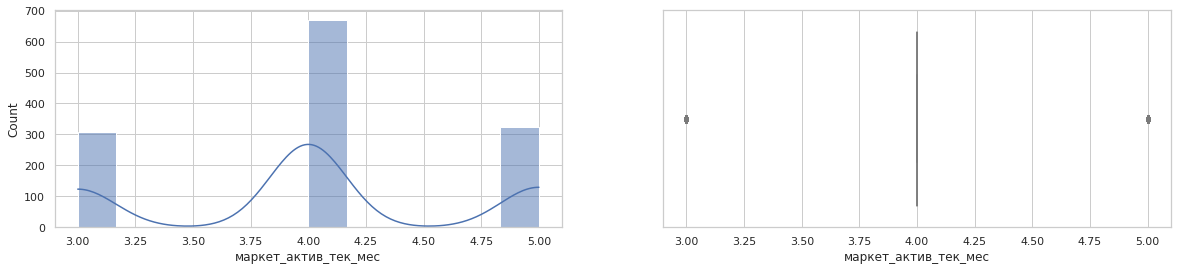

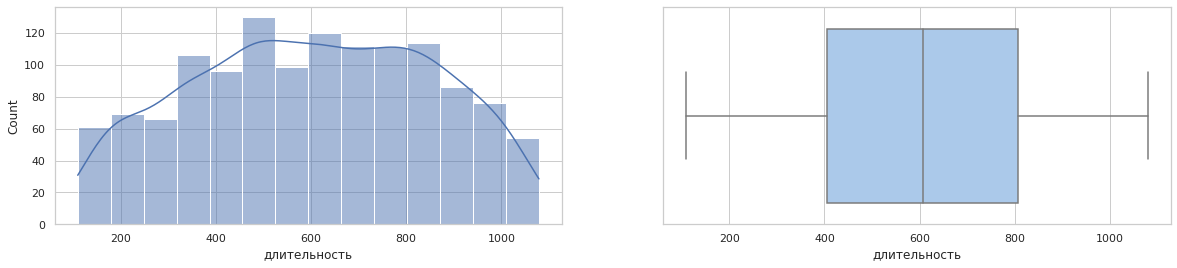

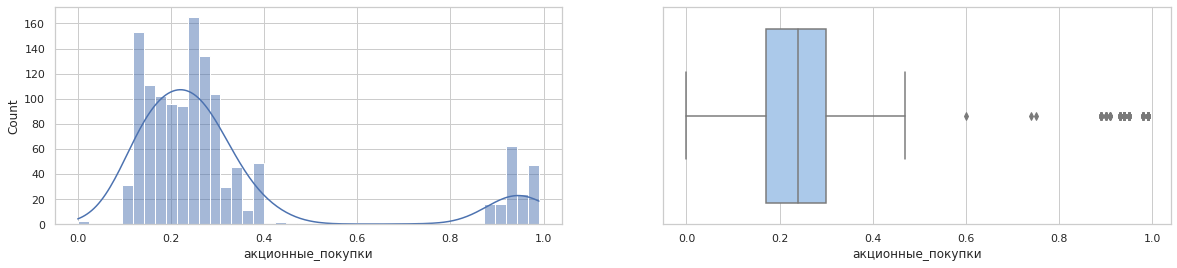

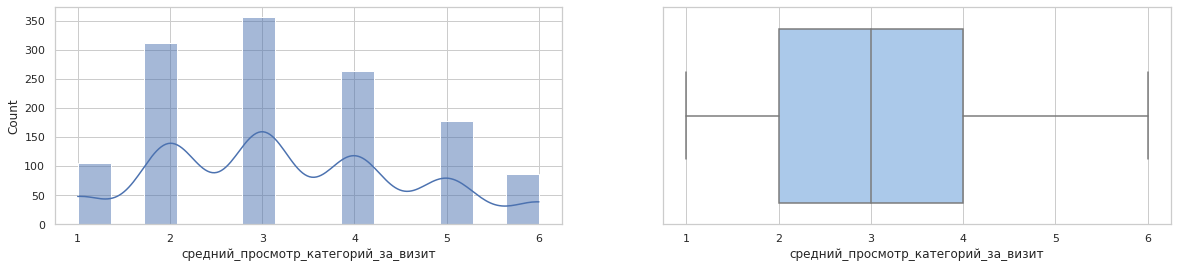

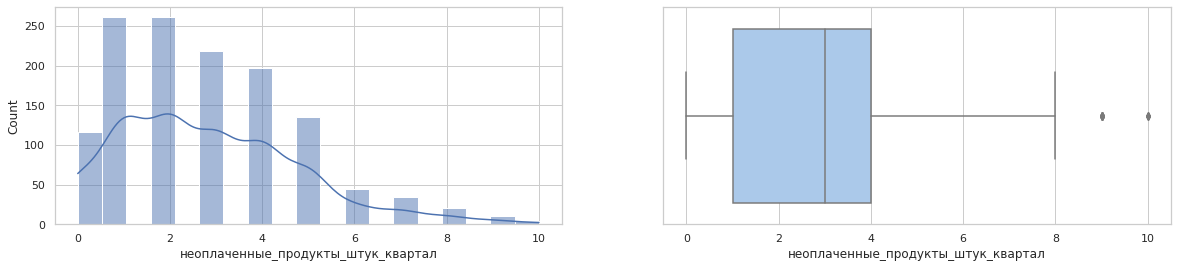

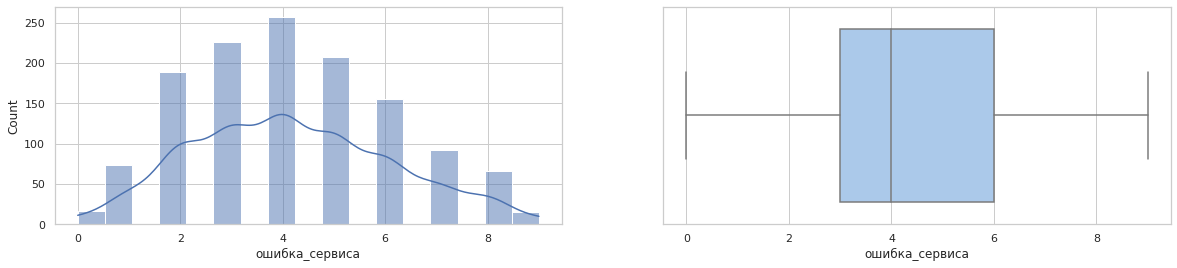

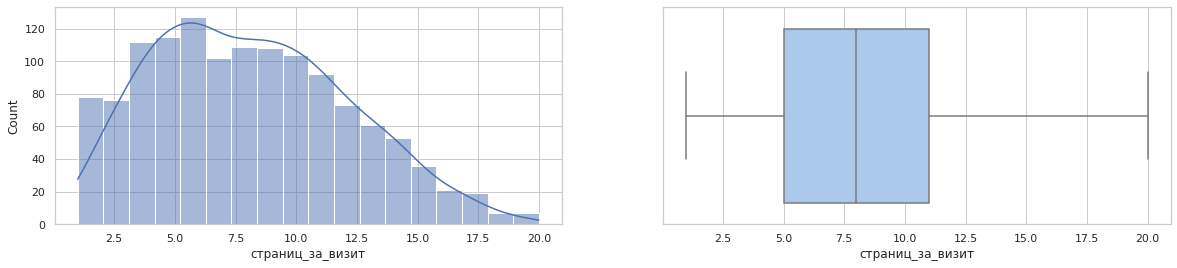

In [35]:
for i in num_columns:
    plt.rcParams['figure.figsize'] = [20, 4]
    sns.set(style='whitegrid')
    plt.subplot(1, 2, 1)
    sns.histplot(data = market_file, x = market_file[i], kde=True)
    plt.subplot(1, 2, 2)
    sns.boxplot(data = market_file, x = market_file[i], palette='pastel')
    plt.show()

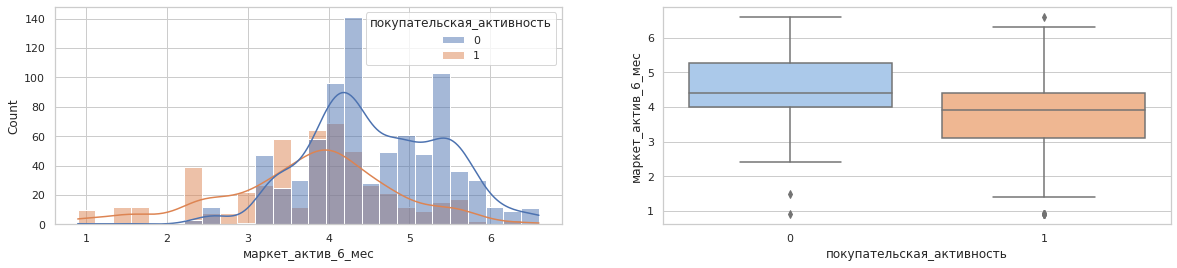

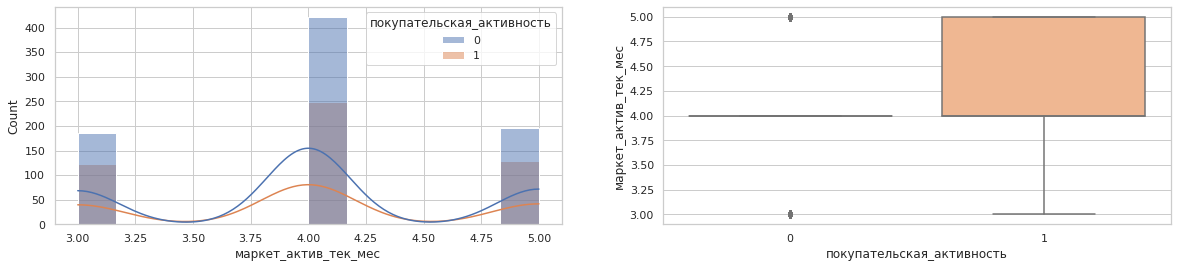

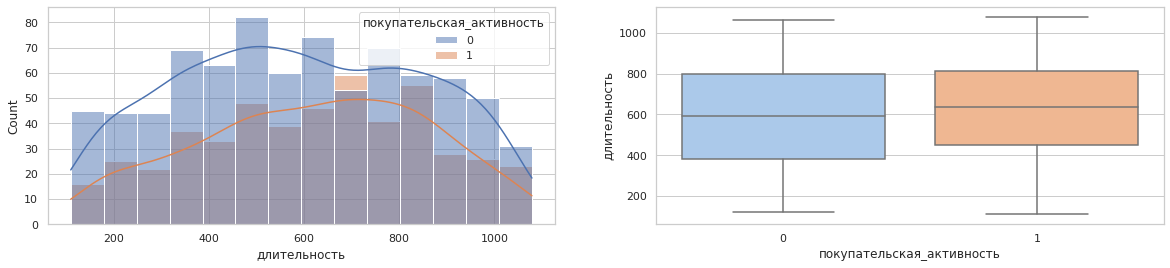

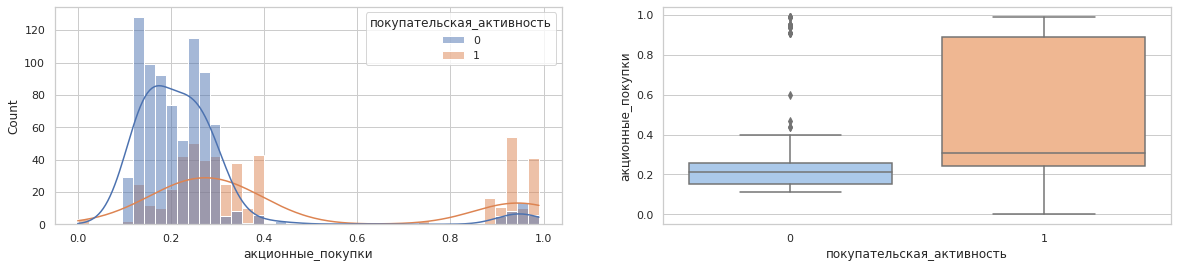

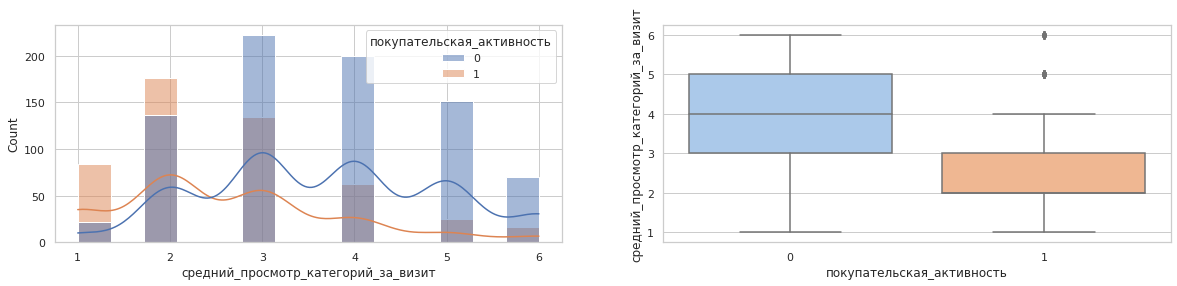

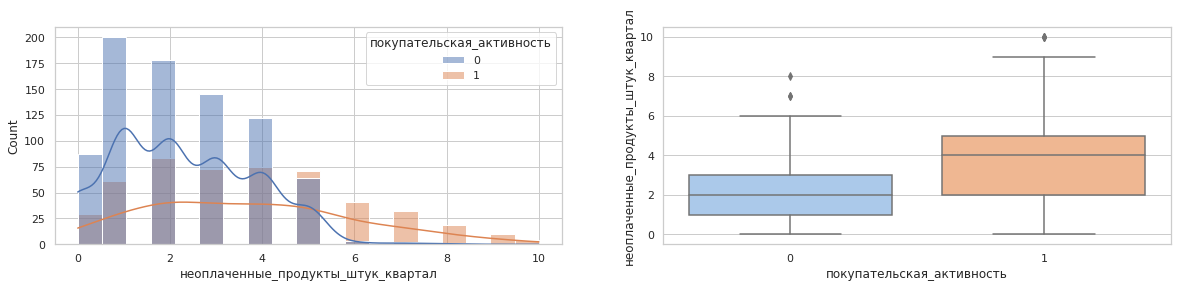

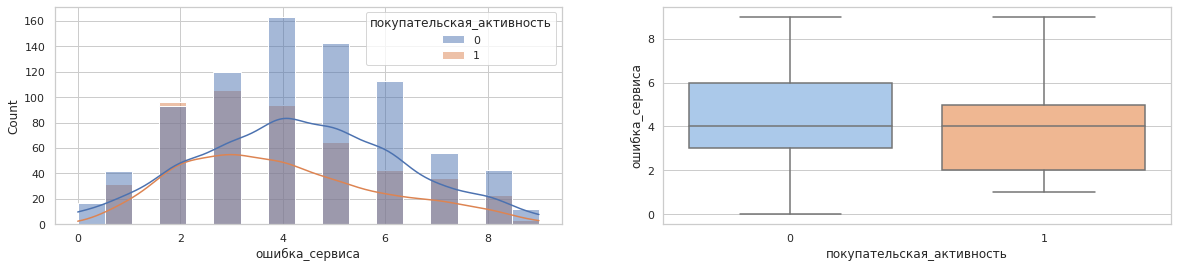

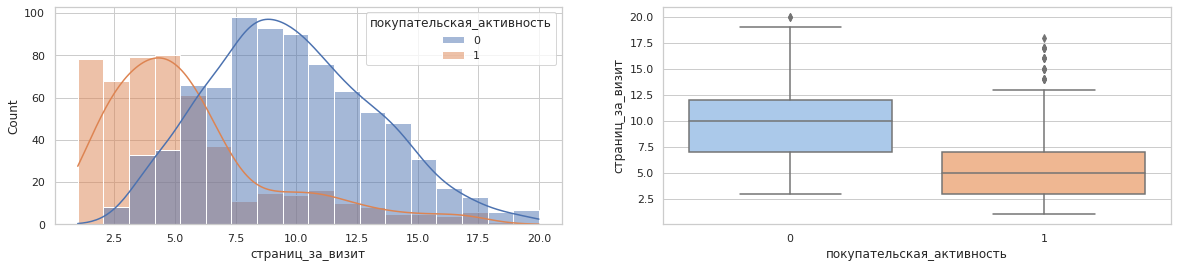

In [36]:
for i in num_columns:
    plt.rcParams['figure.figsize'] = [20, 4]
    sns.set(style='whitegrid')
    plt.subplot(1, 2, 1)
    sns.histplot(data = market_file, x = market_file[i], hue = 'покупательская_активность', kde=True)
    plt.subplot(1, 2, 2)
    sns.boxplot(data = market_file, y = market_file[i], x = market_file['покупательская_активность'], palette='pastel')
    plt.show()

Подведу итоги:
- В колонке _маркет\_актив\_6\_мес_ есть выбросы, можно будет их удалить.
- В _маркет\_актив\_тек\_мес_ указаны целые значения, то есть это дискретная величина, все данные нужно учесть.
- В _акционнные\_покупки_ на первый взгляд есть выбросы, но в этой таблице хранятся данные о среднемесячной доли покупок по акции. Значит, есть клиенты, которые совершали покупки только по акции.
- В _неоплаченные\_продукты\_штук\_квартал_ есть выбросы, удалю их.

In [37]:
display(market_file.loc[(market_file['маркет_актив_6_мес'] < 2) |
                (market_file['неоплаченные_продукты_штук_квартал'] > 8.1)])
display(market_file.loc[(market_file['маркет_актив_6_мес'] < 2) |
                (market_file['неоплаченные_продукты_штук_квартал'] > 8.1)]['id'].count())

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
30,215378,1,стандарт,да,1.7,3,488,0.39,Техника для красоты и здоровья,5,1,4,3
32,215380,1,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7
38,215386,1,стандарт,да,1.5,3,495,0.98,Домашний текстиль,2,3,7,5
47,215395,1,премиум,да,1.5,5,645,0.27,Товары для детей,3,3,6,5
55,215403,1,премиум,да,1.7,5,771,0.39,Техника для красоты и здоровья,1,8,2,5
61,215409,1,премиум,да,1.4,4,857,0.95,Кухонная посуда,3,4,5,5
63,215411,1,стандарт,да,1.7,4,756,0.33,Товары для детей,2,3,7,4
70,215418,1,стандарт,нет,1.7,4,472,0.94,Домашний текстиль,2,6,4,3
72,215420,1,стандарт,да,3.5,5,449,0.35,Домашний текстиль,1,9,2,2
73,215421,1,премиум,нет,4.0,5,523,0.94,Техника для красоты и здоровья,1,10,7,5


49

Наша цель &mdash; удержать активных постоянных пользователей, для них характерным будет скорее высокая маркетинговая активность, чем низкая. Вне зависимости от того, аномальные/некорректные данные или нет, они влияют на точность модели, при этом их немного &mdash; 49.

In [38]:
#to_drop = market_file.loc[(market_file['маркет_актив_6_мес'] < 2) |
#                                               (market_file['неоплаченные_продукты_штук_квартал'] > 8.1)]
#market_file = market_file.drop(to_drop.index)
#market_file.loc[(market_file['маркет_актив_6_мес'] < 2) |
#                (market_file['неоплаченные_продукты_штук_квартал'] > 8.1)]['id'].count()

#### market_money

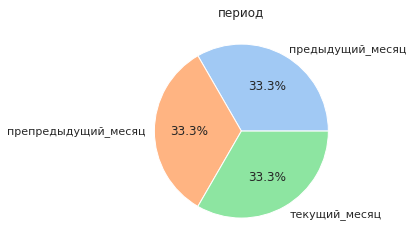

In [39]:
plt.title('период')
pie_diag(market_money, 'период')
plt.show()

Круговая диаграмма ожидаемая, так как структура данных предполагала запись выручки по каждому потребителю за последние три месяца.

<AxesSubplot:xlabel='период', ylabel='выручка'>

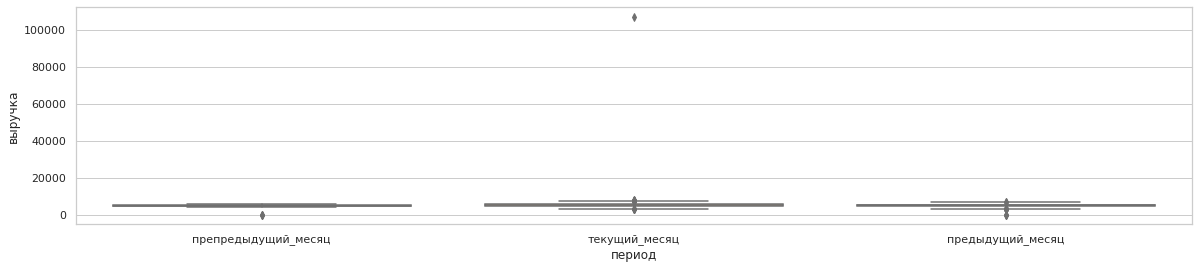

In [40]:
sns.boxplot(data = market_money, x = 'период', y = 'выручка', palette='pastel')

Есть выброс. Его нужно сразу удалить, так как он мешает адекватно отобразить данные.

In [41]:
_ = market_money.loc[market_money['выручка'] > 100000]['id'].values[0]
market_money.loc[market_money['id'] == _].index
market_money = market_money.drop(market_money.loc[market_money['id'] == _].index) # таким образом удалю все записи об
                                                                                  # этом покупателе

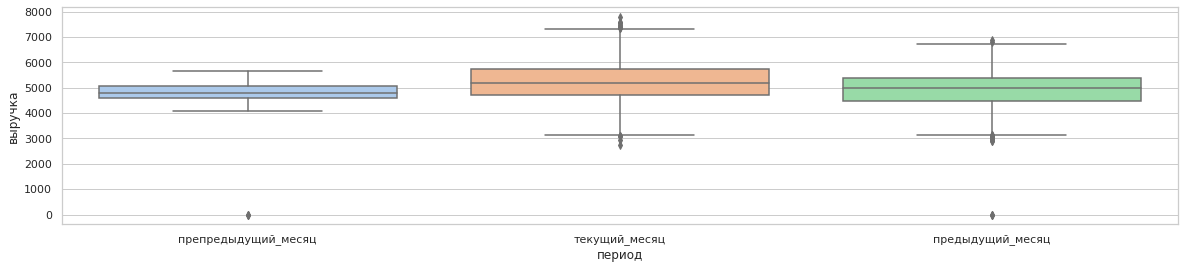

In [42]:
sns.boxplot(data = market_money, x = 'период', y = 'выручка', palette='pastel')
plt.show()

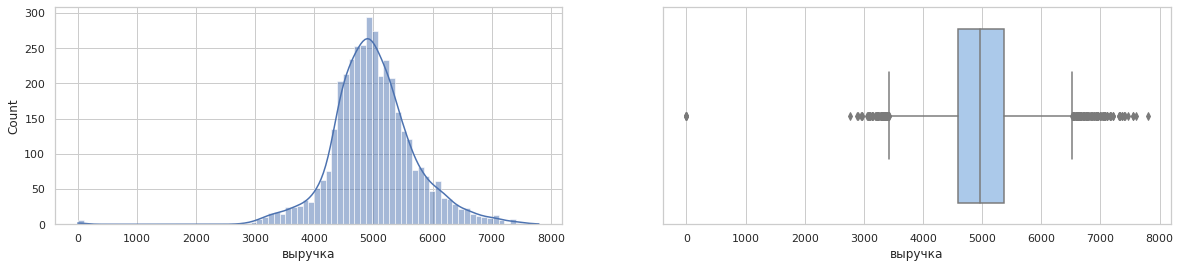

In [43]:
plt.subplot(1, 2, 1)
sns.histplot(data = market_money['выручка'], kde=True)
plt.subplot(1, 2, 2)
sns.boxplot(x = market_money['выручка'], palette='pastel')
plt.show()

In [44]:
display(market_money.loc[market_money['выручка'] < 2000])
_ = market_money.loc[market_money['выручка'] < 2000]['id'].values
_ = list(set(_.tolist()))
display(_)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


[215348, 215357, 215359]

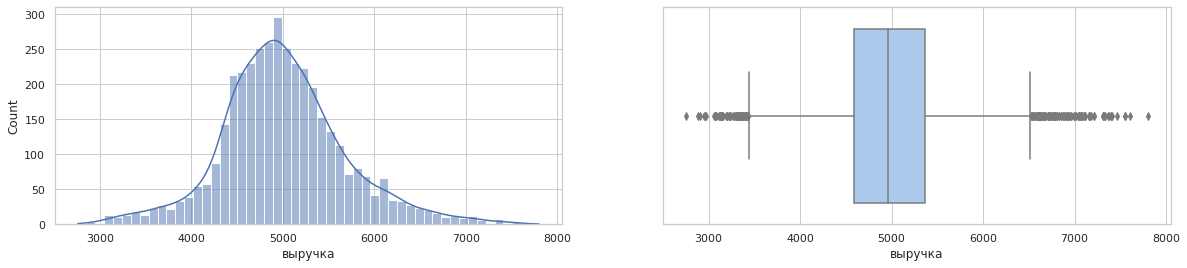

In [45]:
for i in _:
    market_money = market_money.drop(market_money.loc[market_money['id'] == i].index)
plt.subplot(1, 2, 1)
sns.histplot(data = market_money['выручка'], kde=True)
plt.subplot(1, 2, 2)
sns.boxplot(x = market_money['выручка'], palette='pastel')
plt.show()

На этом заканчиваю с датасетом **market_money**.

#### market_time

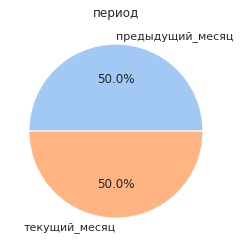

In [46]:
plt.title('период')
pie_diag(market_time, 'период')
plt.show()

Здесь тоже распределение, какое и ожидалось.

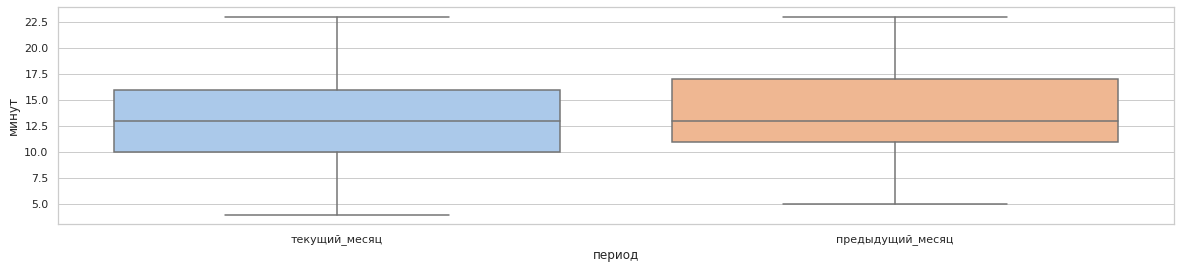

In [47]:
sns.boxplot(data = market_time, x = 'период', y = 'минут', palette='pastel')
plt.show()

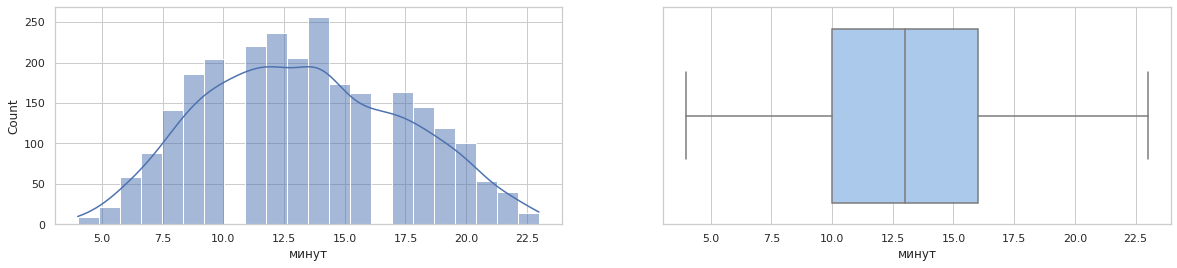

In [48]:
plt.subplot(1, 2, 1)
sns.histplot(data = market_time['минут'], kde=True)
plt.subplot(1, 2, 2)
sns.boxplot(x = market_time['минут'], palette='pastel')
plt.show()

В этом датасете нет выбросов.

#### money

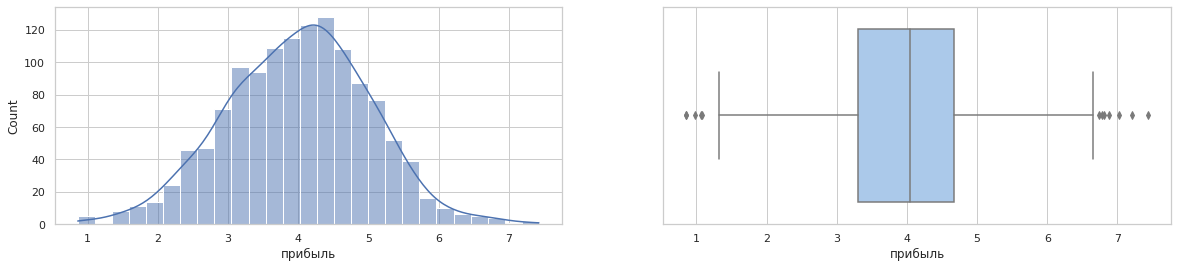

In [49]:
plt.subplot(1, 2, 1)
sns.histplot(data = money['прибыль'], kde=True)
plt.subplot(1, 2, 2)
sns.boxplot(x = money['прибыль'], palette='pastel')
plt.show()

В этом датасете не было никаких категориальных переменных. Выбросы не аномальные, так что удалять не буду, так как они могут быть сигналами каких-либо тенденций в потребительском поведении.

Промежуточный вывод: построил круговые диаграммы для категориальных переменных, гистограммы и боксплоты для количественных. Удалил выбросы, где посчитал это необходимым.

### Объединение таблиц

Преобразовать нужно датасеты **market_money** и **market_time**, затем по _id_ соединить с **market_file**.

In [50]:
market_money

,id,период,выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


In [51]:
t1 = pd.pivot_table(market_money, index=['id'], columns=['период'], values='выручка').reset_index()\
                                                                                     .rename_axis(None, axis=1)
t1.rename(columns={'препредыдущий_месяц': 'выручка_за_-2_мес',
                   'предыдущий_месяц': 'выручка_за_-1_мес',
                   'текущий_месяц': 'выручка_за_0_мес'}, inplace=True)
t1.head()

,id,выручка_за_-1_мес,выручка_за_-2_мес,выручка_за_0_мес
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [52]:
market_time

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
...,...,...,...
2595,216645,текущий_месяц,18
2596,216646,предыдущий_месяц,18
2597,216646,текущий_месяц,7
2598,216647,текущий_месяц,10


In [53]:
t2 = pd.pivot_table(market_time, index=['id'], columns=['период'], values='минут').reset_index()\
                                                                                  .rename_axis(None, axis=1)
t2.rename(columns={'предыдущий_месяц': 'минут_на_сайте_за_-1_мес',
                    'текущий_месяц': 'минут_на_сайте_за_0_мес'}, inplace=True)
t2.head()

,id,минут_на_сайте_за_-1_мес,минут_на_сайте_за_0_мес
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [54]:
# df - имя итоговой таблицы
df = pd.merge(market_file, t1, how='inner', on='id')
df = pd.merge(df, t2, how='inner', on='id')
df

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_-1_мес,выручка_за_-2_мес,выручка_за_0_мес,минут_на_сайте_за_-1_мес,минут_на_сайте_за_0_мес
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,0,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1292,216644,0,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1293,216645,0,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1294,216646,0,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


Промежуточный вывод: получившийся датасет **df** учитывает все удаления, которые были сделаны на предыдущем этапе. Он сделан на основе **market_file**, к нему добавлены столбцы о выручке по месяцам и о времени, проведенном на сайте в минутах. Итоговая таблица содержит данные о 1248 покупателях из 1300 изначальных, количество данных уменьшилось ровно на 4%.

### Корреляционный анализ данных

В начале работы импортировал библиотеку **phik**, чтобы построить матрицу корреляций входных признаков.  _Покупательская\_активность_ &mdash; целевой признак. Методу **phik_matrix** нужно передать названия количественных переменных. Из новых таблиц в **df** были добавлены только количественные переменные, скопирую код из этапа построения диаграмм для количественных переменных, категориальные остались теми же.

In [55]:
num_columns = df.columns.to_list()
num_columns = [x for x in num_columns if x not in cat_columns]
num_columns.remove('id')
num_columns.remove(target)
num_columns

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'выручка_за_-1_мес',
 'выручка_за_-2_мес',
 'выручка_за_0_мес',
 'минут_на_сайте_за_-1_мес',
 'минут_на_сайте_за_0_мес']

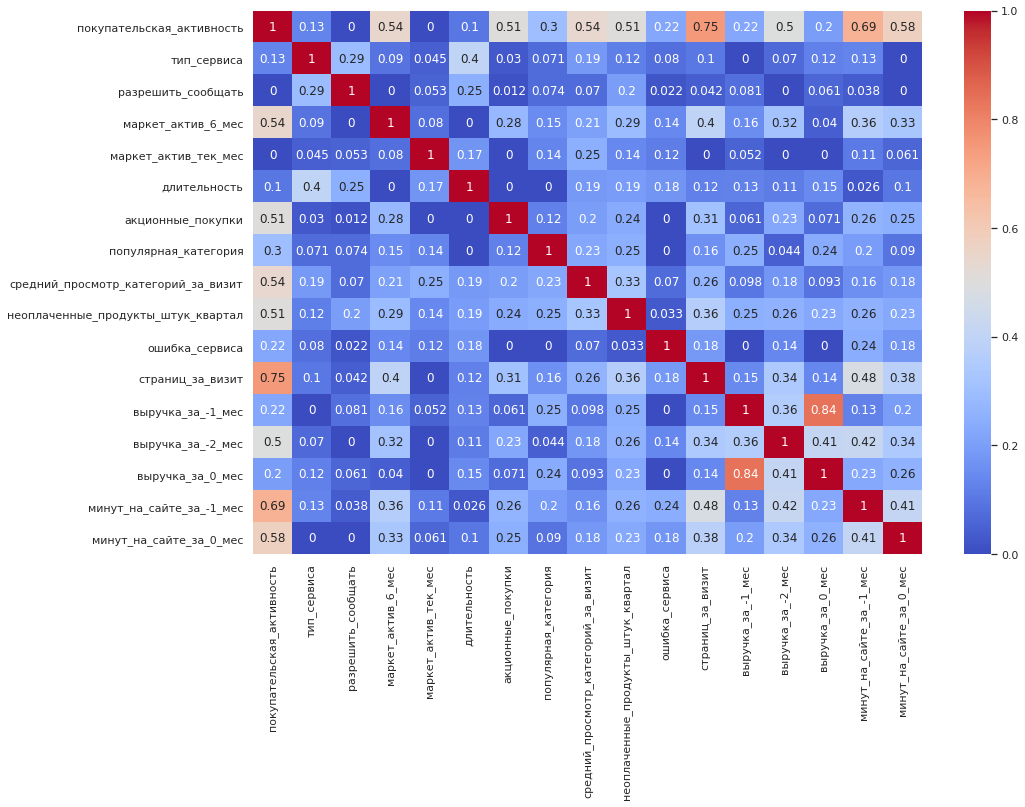

In [56]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.drop('id', axis=1).phik_matrix(interval_cols=num_columns), annot=True, cmap='coolwarm')
plt.show()

In [57]:
df_ = df[['выручка_за_-1_мес', 'выручка_за_0_мес']]

vif_df = pd.DataFrame() 
vif_df['feature'] = df_.columns

vif_df["VIF"] = [variance_inflation_factor(df_.values, i) 
                          for i in range(len(df_.columns))]
vif_df

,feature,VIF
0,выручка_за_-1_мес,135.561158
1,выручка_за_0_мес,135.561158


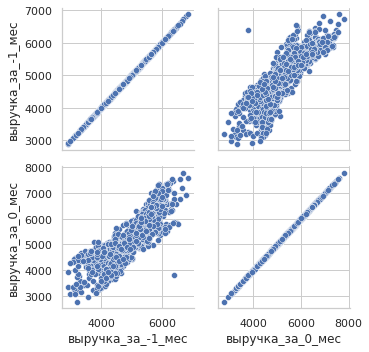

In [58]:
g = sns.PairGrid(df[['выручка_за_-1_мес', 'выручка_за_0_мес']])
g.map(sns.scatterplot)

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column
  warnings.warn(


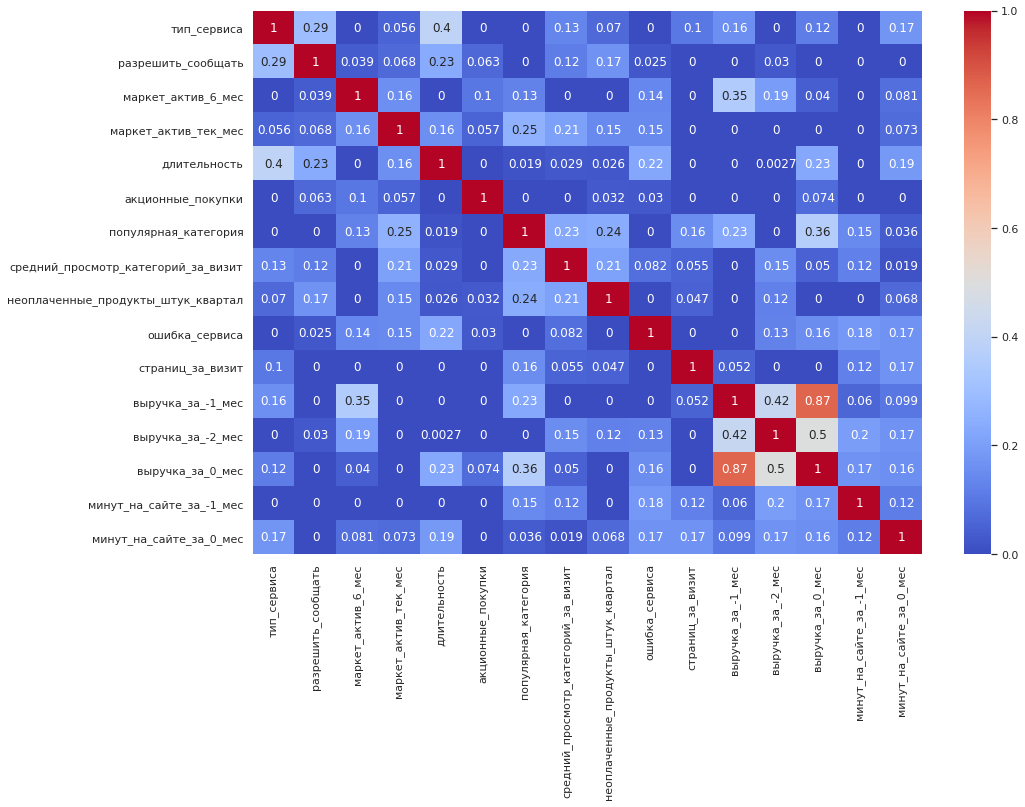

In [59]:
df_ = df[df['покупательская_активность'] == 0]
plt.figure(figsize=(15, 10))
sns.heatmap(df_.drop('id', axis=1).phik_matrix(interval_cols=num_columns), annot=True, cmap='coolwarm')
plt.show()

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column
  warnings.warn(


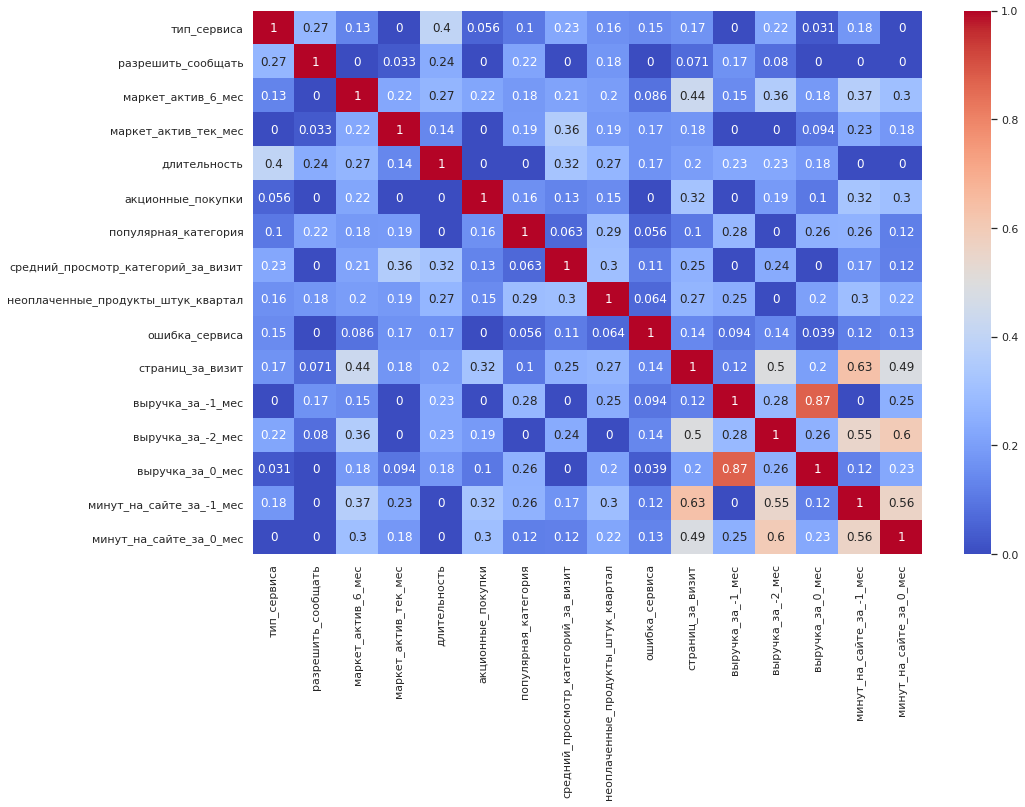

In [60]:
df_ = df[df['покупательская_активность'] == 1]
plt.figure(figsize=(15, 10))
sns.heatmap(df_.drop('id', axis=1).phik_matrix(interval_cols=num_columns), annot=True, cmap='coolwarm')
plt.show()

Есть подозрение на мультиколлинеарность у признаков _выручка\_за\_\-1\_мес_ и _выручка\_за\_0\_мес_. Но оба эти признака важны для построения модели. К тому же, значение корреляции считается высоким, если оно превышает 0.9. Из этого заключаю, что мультиколлинеарности не наблюдается.

В данном проекте целевой признак &mdash; покупательская активность. Диаграммы рассеяния для него и всех количественных признаков будут выглядеть как множество точек на двух вертикальных прямых, так как покупательская активность &mdash; категориальный признак. Scatterplot строится для двух количесвтенных переменных, поэтому не вижу смысла здесь строить их.

Промежуточный вывод: построил матрицу корреляций **phik_matrix**, мультиколлинеарности не наблюдается.

### Использование пайплайнов

Надо создать пайплайны с кодированием и масштабированием данных.

Категориальные и количественные переменные выделены, посмотрю на них еще раз.

In [61]:
#display(cat_columns)
display(num_columns)

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'выручка_за_-1_мес',
 'выручка_за_-2_мес',
 'выручка_за_0_мес',
 'минут_на_сайте_за_-1_мес',
 'минут_на_сайте_за_0_мес']

_популярная\_категория_ &mdash; колонка, которая подразумевает 5 значений, когда остальные только два.

In [62]:
ohe_columns = ['тип_сервиса', 'разрешить_сообщать'] # покупательская активность не включена, это целевой признак
ord_columns = ['популярная_категория']
categories = pd.unique(df['популярная_категория']).tolist()
categories

['Товары для детей',
 'Домашний текстиль',
 'Косметика и аксессуары',
 'Кухонная посуда',
 'Техника для красоты и здоровья',
 'Мелкая бытовая техника и электроника']

In [63]:
X = df.drop(['id', 'покупательская_активность'], axis=1)
y = df['покупательская_активность']

In [64]:
simplefilter(action='ignore', category=FutureWarning)

RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['покупательская_активность'])

display(X_test)
display(y_test)

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[categories],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            penalty='l2'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для SVC()
    {
        'models': [SVC()],
        'models__kernel': ['rbf','sigmoid', 'linear', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='precision',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

y_test_pred = randomized_search.predict(X_test)
print(f'Метрика Precision на тестовой выборке: {precision_score(y_test, y_test_pred)}')

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_-1_мес,выручка_за_-2_мес,выручка_за_0_мес,минут_на_сайте_за_-1_мес,минут_на_сайте_за_0_мес
809,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17
302,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9
955,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11
149,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9
582,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,премиум,нет,0.9,4,690,0.24,Домашний текстиль,2,5,7,4,3662.0,4488.0,4158.6,11,10
881,премиум,да,3.9,4,1048,0.21,Техника для красоты и здоровья,3,0,6,14,4325.0,4553.0,4257.4,15,17
364,стандарт,да,2.4,4,952,0.30,Техника для красоты и здоровья,3,5,2,3,3067.0,4165.0,3343.9,13,14
789,стандарт,нет,4.0,4,748,0.28,Косметика и аксессуары,4,0,4,9,5660.5,4885.0,6462.6,14,10


809    0
302    1
955    0
149    1
582    1
      ..
77     1
881    0
364    1
789    0
318    1
Name: покупательская_активность, Length: 324, dtype: int64

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                     

### Анализ важности признаков

In [65]:
ohe_encoder = OneHotEncoder(drop='first', sparse_output=False)

X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = ohe_encoder.transform(X_test[ohe_columns])

ohe_encoder_names = ohe_encoder.get_feature_names_out()

df_ohe_train = pd.DataFrame(X_train_ohe, columns=ohe_encoder_names)
df_ohe_test = pd.DataFrame(X_test_ohe, columns=ohe_encoder_names)

ord_encoder = OrdinalEncoder(categories = [categories], handle_unknown = 'use_encoded_value', unknown_value = np.nan)

X_train_ord = ord_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ord_encoder.transform(X_test[ord_columns])

df_ord_train = pd.DataFrame(X_train_ord, columns=['ordinal'])
df_ord_test = pd.DataFrame(X_test_ord, columns=['ordinal'])

scaler = StandardScaler()

scaler.fit(X_train[num_columns])
X_train_scaled = scaler.transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

df_scaled_train = pd.DataFrame(X_train_scaled, columns=num_columns)
df_scaled_test = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train_new = pd.concat([df_ohe_train, df_ord_train], axis=1)
X_train_new = pd.concat([X_train_new, df_scaled_train], axis=1)
X_test_new = pd.concat([df_ohe_test, df_ord_test], axis=1)
X_test_new = pd.concat([X_test_new, df_scaled_test], axis=1)

model = SVC(kernel='poly', probability=True)
model = model.fit(X_train_new, y_train)

y_pred = model.predict(X_test_new)

precision = precision_score(y_test, y_pred)
precision # для проверки

0.946236559139785

In [66]:
dff = randomized_search.best_estimator_.named_steps['preprocessor']
D = dff.transform(X_train)
D = pd.DataFrame(D, columns=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())
D

,ohe__тип_сервиса_стандарт,ohe__разрешить_сообщать_нет,ord__популярная_категория,num__маркет_актив_6_мес,num__маркет_актив_тек_мес,num__длительность,num__акционные_покупки,num__средний_просмотр_категорий_за_визит,num__неоплаченные_продукты_штук_квартал,num__ошибка_сервиса,num__страниц_за_визит,num__выручка_за_-1_мес,num__выручка_за_-2_мес,num__выручка_за_0_мес,num__минут_на_сайте_за_-1_мес,num__минут_на_сайте_за_0_мес
0,1.0,0.0,5.0,1.228498,-0.034940,-0.386673,-0.678649,-0.926450,0.554520,1.446808,1.973431,0.308218,-1.451803,0.921997,1.641373,-1.744172
1,1.0,0.0,4.0,0.829033,-0.034940,-1.626840,-0.354956,0.559539,1.048557,-1.130716,-1.316315,2.067366,-0.714636,-1.724921,-0.647600,-0.064910
2,1.0,0.0,5.0,0.030104,1.380136,1.555325,-0.597726,1.302533,-0.927589,-0.615212,0.708144,-1.204835,-0.629125,-1.714569,-0.138940,-0.784593
3,1.0,0.0,3.0,1.328364,-0.034940,-1.056603,2.517826,-0.926450,2.036630,0.415798,-0.051028,-0.035885,1.266868,-0.562990,0.115391,1.374458
4,0.0,0.0,0.0,-0.668960,1.380136,1.060853,0.292432,-0.183455,-0.433553,-1.130716,-0.810200,-1.772856,-0.437461,-0.760751,-0.901931,-0.784593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,1.0,0.0,2.0,-0.269495,-1.450017,-0.697712,-0.638188,0.559539,-0.927589,-1.130716,1.214259,0.989271,-0.455153,1.630697,0.878382,2.094141
968,1.0,0.0,5.0,-0.768826,-0.034940,0.235404,-0.435879,-0.926450,-0.433553,-1.130716,-0.051028,-0.412181,0.862901,-1.005869,1.895703,1.134563
969,1.0,0.0,0.0,1.028765,-0.034940,-1.016726,-0.759573,-1.669444,2.036630,-0.615212,0.455087,0.595806,1.281611,0.412484,0.369721,1.374458
970,1.0,1.0,5.0,0.329702,-0.034940,1.168520,-0.638188,1.302533,-1.421625,1.962313,-0.051028,-0.133178,0.429447,-0.421155,1.132712,1.614352


In [67]:
X_train_new

,тип_сервиса_стандарт,разрешить_сообщать_нет,ordinal,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_-1_мес,выручка_за_-2_мес,выручка_за_0_мес,минут_на_сайте_за_-1_мес,минут_на_сайте_за_0_мес
0,1.0,0.0,5.0,1.228498,-0.034940,-0.386673,-0.678649,-0.926450,0.554520,1.446808,1.973431,0.308218,-1.451803,0.921997,1.641373,-1.744172
1,1.0,0.0,4.0,0.829033,-0.034940,-1.626840,-0.354956,0.559539,1.048557,-1.130716,-1.316315,2.067366,-0.714636,-1.724921,-0.647600,-0.064910
2,1.0,0.0,5.0,0.030104,1.380136,1.555325,-0.597726,1.302533,-0.927589,-0.615212,0.708144,-1.204835,-0.629125,-1.714569,-0.138940,-0.784593
3,1.0,0.0,3.0,1.328364,-0.034940,-1.056603,2.517826,-0.926450,2.036630,0.415798,-0.051028,-0.035885,1.266868,-0.562990,0.115391,1.374458
4,0.0,0.0,0.0,-0.668960,1.380136,1.060853,0.292432,-0.183455,-0.433553,-1.130716,-0.810200,-1.772856,-0.437461,-0.760751,-0.901931,-0.784593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,1.0,0.0,2.0,-0.269495,-1.450017,-0.697712,-0.638188,0.559539,-0.927589,-1.130716,1.214259,0.989271,-0.455153,1.630697,0.878382,2.094141
968,1.0,0.0,5.0,-0.768826,-0.034940,0.235404,-0.435879,-0.926450,-0.433553,-1.130716,-0.051028,-0.412181,0.862901,-1.005869,1.895703,1.134563
969,1.0,0.0,0.0,1.028765,-0.034940,-1.016726,-0.759573,-1.669444,2.036630,-0.615212,0.455087,0.595806,1.281611,0.412484,0.369721,1.374458
970,1.0,1.0,5.0,0.329702,-0.034940,1.168520,-0.638188,1.302533,-1.421625,1.962313,-0.051028,-0.133178,0.429447,-0.421155,1.132712,1.614352


  0%|          | 0/324 [00:00<?, ?it/s]

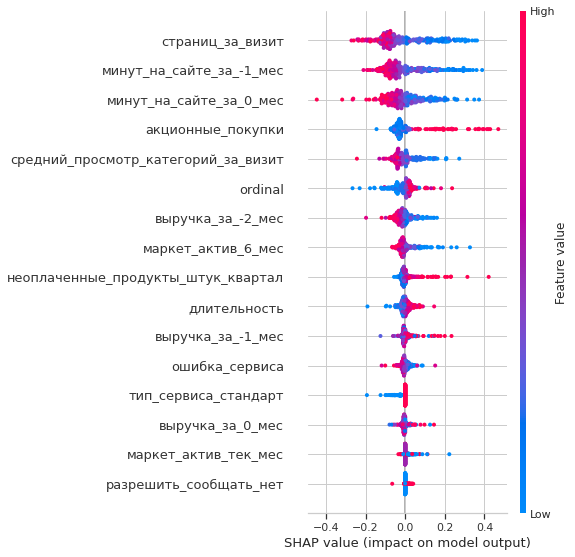

In [68]:
X_train_summary = shap.kmeans(X_train_new, 10)

ex = shap.KernelExplainer(model.predict, X_train_summary)
shap_values = ex.shap_values(X_test_new)
shap.summary_plot(shap_values, X_test_new)

Промежуточный вывод: чем ниже значения _страниц_за_визит_, _минут_на_сайте_за__-1_мес_, _минут_на_сайте_за_0_мес_, _средний_просмотр_категорий_за_визит_, тем выше вероятность принадлежности к классу _1_, то есть тем выше вероятность, что покупательская активность снизится. Чем выше значения _акционные_покупки_, тем выше вероятность снижения активности.

### Новая сегментация

Сегмент &mdash; покупатели с низкими значениями в _страниц\_за\_визит_, _минут\_на\_сайте\_за\_\-1_мес_, _минут\_на\_сайте\_за\_0\_мес_, _средний\_просмотр\_категорий\_за\_визит_ или высокими в _акционные\_покупки_. Посмтрю на медианные значения и выберу те данные, которые будут ниже / выше этих значений.

In [69]:
df_new = df[(df['страниц_за_визит'] < df['страниц_за_визит'].median()) |
            (df['минут_на_сайте_за_-1_мес'] < df['минут_на_сайте_за_-1_мес'].median()) |
            (df['минут_на_сайте_за_0_мес'] < df['минут_на_сайте_за_0_мес'].median()) |
            (df['средний_просмотр_категорий_за_визит'] < df['средний_просмотр_категорий_за_визит'].median()) |
            (df['акционные_покупки'] > df['акционные_покупки'].median())]
df_new

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_-1_мес,выручка_за_-2_мес,выручка_за_0_мес,минут_на_сайте_за_-1_мес,минут_на_сайте_за_0_мес
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,0,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1292,216644,0,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1293,216645,0,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1294,216646,0,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [70]:
money_new = money[money['id'].isin(df_new['id'].values.tolist())]
display(money_new)
money_new['прибыль'].describe()

,id,прибыль
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
...,...,...
1295,216643,4.44
1296,216644,6.11
1297,216645,3.29
1298,216646,4.03


count    1117.000000
mean        3.993635
std         1.012487
min         0.860000
25%         3.300000
50%         4.020000
75%         4.660000
max         7.430000
Name: прибыль, dtype: float64

Среднее и медиана покупателей техники вполне соотносятся с данными, полученными на этапе исследовательского анализа.

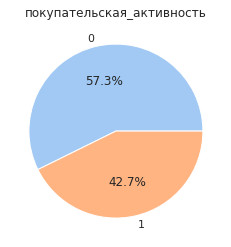

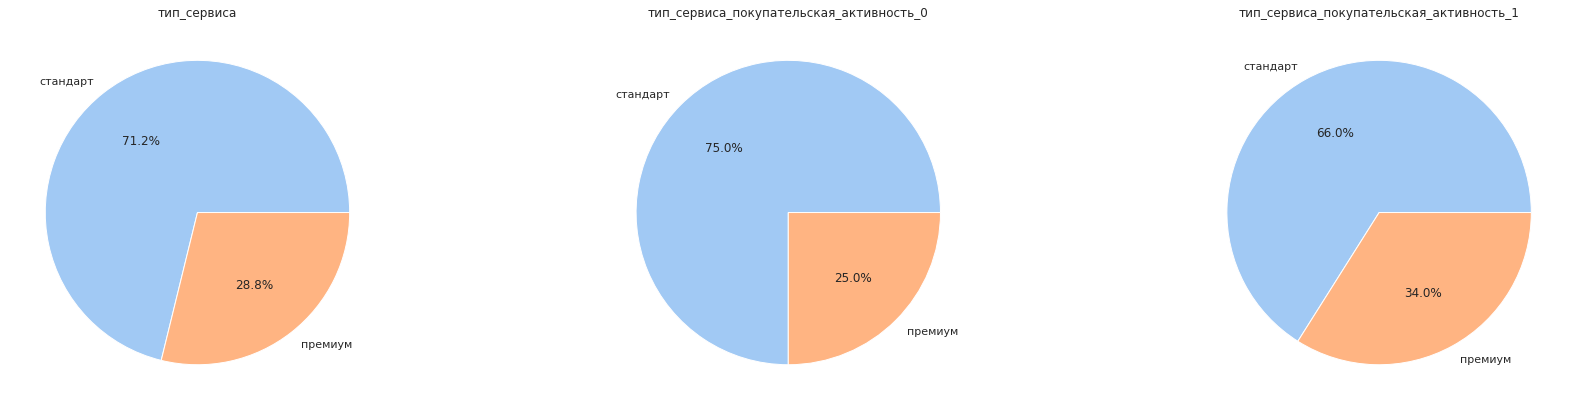

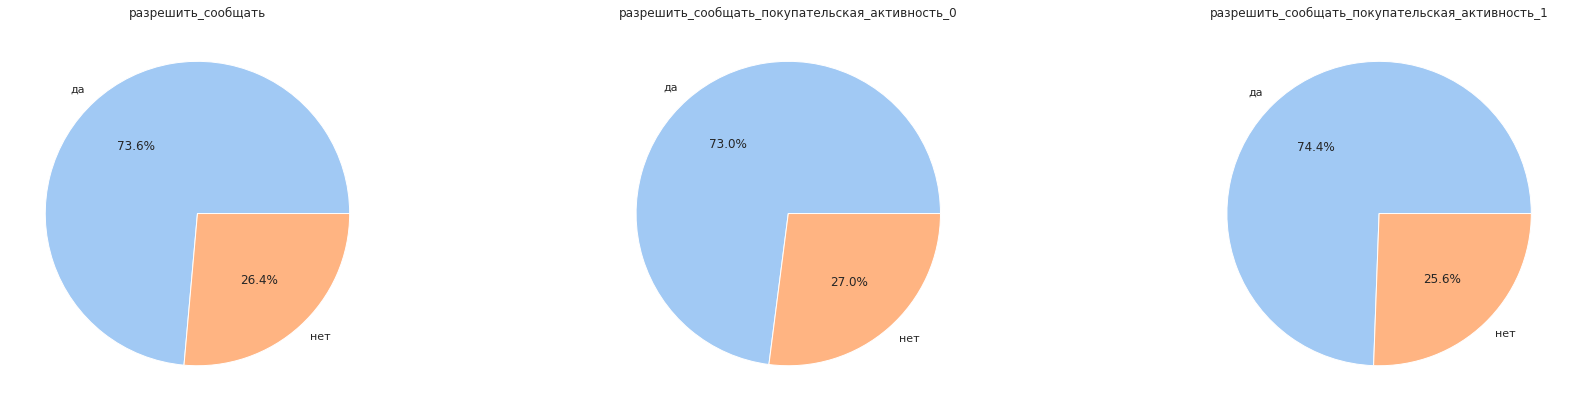

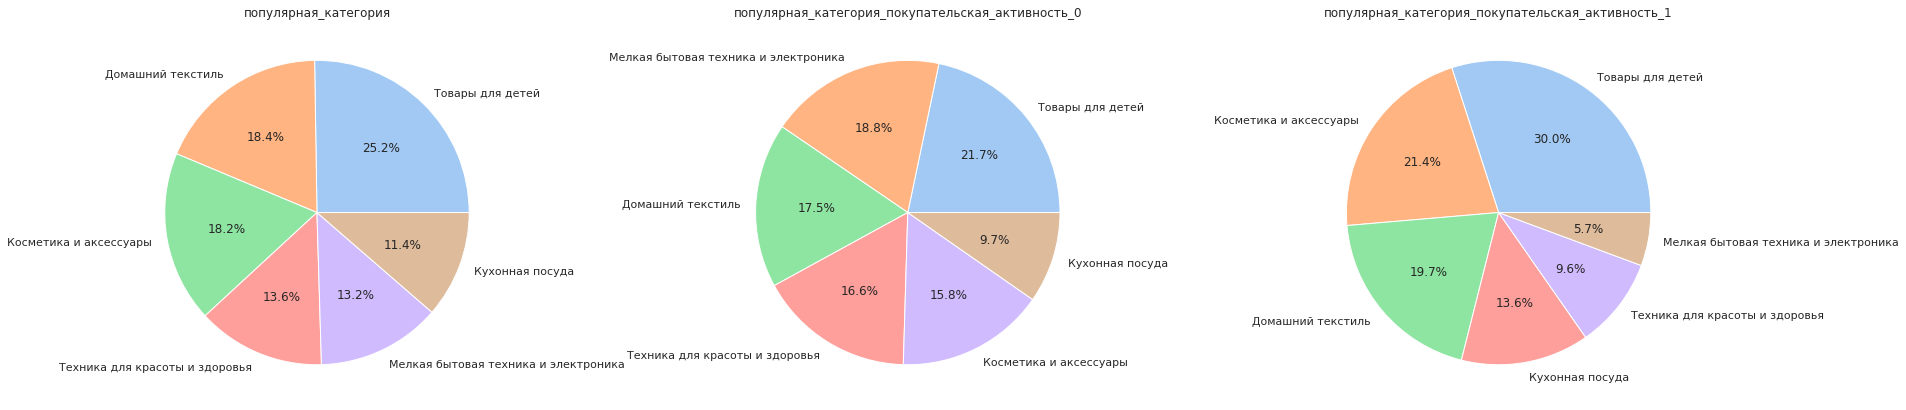

In [71]:
cat_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
target = 'покупательская_активность'
plt.title(target)
pie_diag(df_new, target)
plt.show()
for i in cat_columns:
    plt.rcParams['figure.figsize'] = [30, 7]
    plt.subplot(1, 3, 1)
    plt.title(i)
    pie_diag(df_new, i)
    plt.subplot(1, 3, 2)
    plt.title(i+'_покупательская_активность_0')
    pie_diag(df_new[df_new[target] == 0], i)
    plt.subplot(1, 3, 3)
    plt.title(i+'_покупательская_активность_1')
    pie_diag(df_new[df_new[target] == 1], i)
    plt.show()

Большую долю тех, у кого снизилась покупательская активность, составляют люди, кто часто покупают детские товары.

In [72]:
df_new = pd.merge(df_new, money_new, how='inner', on='id')
for i in cat_columns:
    display(df_new.groupby(by=i)['прибыль'].median())

тип_сервиса
премиум     3.985
стандарт    4.040
Name: прибыль, dtype: float64

разрешить_сообщать
да     4.02
нет    3.99
Name: прибыль, dtype: float64

популярная_категория
Домашний текстиль                       3.91
Косметика и аксессуары                  4.13
Кухонная посуда                         4.10
Мелкая бытовая техника и электроника    3.99
Техника для красоты и здоровья          3.72
Товары для детей                        4.11
Name: прибыль, dtype: float64

Как раз на товары для детей и тратят обычно больше общего медианного значения. Также на космметику и кухонную посуду. В раз

### Общий вывод

Загрузил данные, проверил корректность загрузки и исправил орфографические ошибки.

Импортировал необходимые библиотеки и методы, выявил неянвые дубликаты и привел данные к нужному виду. Выделил столбец таргета и изменил в нем строковые значения на бинарные. Проверил все датасеты на пропуски и правильыне типа данных.

Построил необходимые диаграммы, гистограммы и боксплоты. Удалил выбросы, где посчитал нужным.

Объединил таблицы в одну, добавил новые признаки: данные о выручке по последним трем месяцам и количеству минут, проведенных на сайте за последние два месяца.

Построил матрицу корреляций **phik**, проверил на мультиколлинеарность.

Использовал пайплайн для выявления лучшей модели. Для этого использовал метрику precision, лучшей моделью стала модель опорных векторов SVC(kernel='poly').

Из всех признаков решил оставить 6, так как на этом количестве признаков метрика precision возросла.

Выбрал сегмент покупателей